## Implementing the collaborative filtering using deep learning
* Randomly Initialise Parameters — these will be the latent factors that help predict whether someone will like a movie.
* Calculate Predictions — this is done by taking the matrix dot product of the movie and user matrices. An example would be if a user’s likening to international films is high, and a movie is foreign; the product of the two will be large and, that movie will rank higher for that user.
* note: This approach could be used for prediction but is very inefficient as it requires a vector to be created and stored for each prediction.

In [1]:
#libreries
from fastai.collab import *
from fastai.tabular.all import *
from fastai import *
from fastai.metrics import *
from fastai.callback.tracker import *

#import acc from fastai.metrics
from fastai.metrics import accuracy, Precision, Recall
#from fastbook import *
import pandas as pd
import numpy as np
set_seed(42)

In [2]:
df = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote.csv')
df.head()

,userId,wine,rate
0,5ccd8030-047b-432c-a630-d784ab415756,Valpolicella Ripasso,3
1,df904a46-c461-4233-9d44-6ac11a8bbddc,Astrale,3
2,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Bricco Riva Bianca,3
3,bc79b0e3-064d-4240-86de-e86499f577e8,3/11 Syrah and blend #4,3
4,5ccd8030-047b-432c-a630-d784ab415756,Valpolicella Ripasso Classico Superiore Pojega,4


In [3]:
# # #importing directly the confusion matrix
# # user_features_df = pd.read_csv('/home/bbruno/all_here/python course/thesis/knn/user_features_df.csv')
# # user_features_df

# #importing the user,movie,rating dataframe
# #we drop a column that was added by mistake by the system
# df = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote.csv')
# df.head()
# # df = pd.read_csv('/home/bbruno/all_here/python course/thesis/knn/df.csv').drop('Unnamed: 0', axis=1)
# # df.tail()

In [4]:
#we create a dataloader
#we pass the title of the movie and not the movie id
dls = CollabDataLoaders.from_df(df, user_name='userId',item_name='wine', bs=64)
#we can see the batch
dls.show_batch()

,userId,wine,rate
0,5bce85c2-b3c7-401f-b77b-992df3544479,Olmera,1
1,09f6ca6e-905f-4afd-bab2-d928fe046f18,Perlugo Extra Brut,1
2,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Tignanello,4
3,441ac739-42f8-48d2-9526-fdedf2d4852f,Bollicina,3
4,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Blanc del Noirs,2
5,dd7e04c1-987c-4520-9ab5-c90e86b7dfe1,Les Folastries Gewürztraminer,4
6,838e0d9d-27e9-4f89-9eab-ba2c2f412759,Red (Winemaker's Blend),1
7,5bce85c2-b3c7-401f-b77b-992df3544479,Pinot noir San Mischael eppan,3
8,cabb87a0-6498-438a-beb7-676f72bddd09,Sauvignon Blanc,4
9,13016d41-00bd-411c-83f5-2b95691696b7,Pinot Grigio,4


In [5]:
#CALCULATE PREDICTIONS USING MATRIX MULTIPLICATION

#we create a matrix with the user features
n_users = len(dls.classes['userId']) #the number of user is the lenght of how many users
#we create a matrix with the movie features
n_movies = len(dls.classes['wine']) #the number of movies is the lenght of how many movies
#we choose the number of factors
n_factors = 5 

#we create a random matrix with the user features(embeddings)
#userFactors = (numberOfUsers x 5)
user_factors = torch.randn(n_users, n_factors)
#we create a random matrix with the movie features(embeddings)
#movieFactors = (numberOfMovies x 5)
movie_factors = torch.randn(n_movies, n_factors)

##########################################
#To calculate the result for a particular movie and user combination, 
#we have to look up the index of the movie in our movie latent factor matrix and
#the index of the user in our user latent factor matrix; 
#then we can do our dot product between the two latent factor vectors

# Create a function that takes the user id and the movie title to make a prediction
def oneHotPredict(userId, title):
    '''In the oneHotPredict function, 
    we use the indices of the user and movie in the embedding matrices
    to look up the corresponding embeddings.
    ----
    We calculate the prediction by taking the dot product
    (element-wise multiplication and then sum) of the user and wine embeddings.
    '''
    userIdx = dls.classes['userId'].o2i[userId]
    movie_idx = dls.classes['wine'].o2i[title]
    
    user_embedding = user_factors[userIdx]
    movie_embedding = movie_factors[movie_idx]
    
    prediction = (user_embedding * movie_embedding).sum()
    return print(f"Predicted rating for user '{userId}' and '{title}': {prediction:.2f}")

In [6]:
# Prediction for user 9 and the movie 'Toy Story (1995)'
prediction = oneHotPredict('13016d41-00bd-411c-83f5-2b95691696b7', 'Pinot Grigio')
#print(f'Predicted rating for user 9 and Toy Story (1995): {prediction:.2f}')

Predicted rating for user '13016d41-00bd-411c-83f5-2b95691696b7' and 'Pinot Grigio': -0.61


## Matrix factorization
* A better approach

In [7]:
def create_params(size):
    """
      Pass tensor shape
      Returns normalised model parameters
    """
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

class DotProductBias(Module):
    """
    Model architecture for collaborative filtering
    """
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        """
        Initialises model with parameters
        :param n_users: number of users
        :param n_movies: number of movies
        :param n_factors: number of factors
        :param y_range: sigmoid limit
        """
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range

    def forward(self, x):
        """
        Applies a forward pass on the dataset passed
        :param x: data as DataLoaders obj
        :return: predictions in sigmoid range (tensor)
        """
        users = self.user_factors[x[:, 0]]
        movies = self.movie_factors[x[:, 1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:, 0]] + self.movie_bias[x[:, 1]]
        return sigmoid_range(res, *self.y_range)

In [8]:
from sklearn.model_selection import KFold

# Assuming dls is your DataLoaders object
kf = KFold(n_splits=8, shuffle=True, random_state=42)  # You can adjust the number of splits

# Store the results of each fold
results = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(dls.train_ds)):
    print(f'Fold {fold + 1}')
    
    # Create new learner for each fold
    model = DotProductBias(n_users, n_movies, 50)
    learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=[mse, rmse, mae])
    
    # Train the model for a fixed number of epochs
    learn.fit_one_cycle(10, 5e-3, wd=0.1)
    
    # Evaluate on the validation set
    val_metrics = learn.validate(dl=dls.valid)
    
    # Store the results
    results.append({
        'fold': fold + 1,
        'train_loss': learn.recorder.final_record[0],
        'valid_loss': val_metrics[0],
        'mse': val_metrics[1],
        'rmse': val_metrics[2],
        'mae': val_metrics[3],
    })

# Display the results for each fold
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)
# # CV = 8
# # # acc = 25.26%, train_loss = 1.724036, valid_loss = 1.724036, mse = 1.724036, rmse = 1.313025, mae =  1.101841
# CV = 3
# # # acc = 25.26%, train_loss = 1.697422, valid_loss = 1.697422, mse = 1.697422, rmse = 1.302852, mae =  1.101104


# #good model
# #Working perfectly without cross validation
# model = DotProductBias(n_users, n_movies, 50)
# learn = Learner(dls, model, loss_func=MSELossFlat(),metrics=[mse, rmse, mae])
# #wd = weight decay (L2 regularization)
# learn.fit_one_cycle(10, 0.05, wd=0.1)
# # # acc = 23.68% , train_loss = 0.306723, valid_loss = 1.585832, mse = 1.585832, rmse = 1.259298, mae = 1.011313

# #This model generalize good
# model = DotProductBias(n_users, n_movies, 50)
# learn = Learner(dls, model, loss_func=MSELossFlat(),metrics=[mse, rmse, mae])
# #wd = weight decay (L2 regularization)
# learn.fit_one_cycle(10, 0.003, wd=0.1)
# # acc = 23.68% , train_loss = 1.274133, valid_loss = 1.778877, mse = 1.778877, rmse = 1.333745, mae = 1.142410

Fold 1


epoch,train_loss,valid_loss,mse,_rmse,mae,time
0,1.944720,1.969541,1.969541,1.403403,1.230283,00:00
1,1.937316,1.935921,1.935921,1.391374,1.214371,00:00
2,1.878108,1.873165,1.873165,1.368636,1.183344,00:00
3,1.761082,1.807161,1.807161,1.344307,1.158162,00:00
4,1.564047,1.755215,1.755215,1.324845,1.133540,00:00
5,1.344581,1.727352,1.727352,1.314288,1.115686,00:00
6,1.143303,1.717784,1.717784,1.310643,1.107372,00:00
7,0.976057,1.714302,1.714302,1.309314,1.103173,00:00
8,0.841463,1.712907,1.712907,1.308781,1.101205,00:00
9,0.739971,1.712706,1.712706,1.308704,1.100911,00:00


Fold 2


epoch,train_loss,valid_loss,mse,_rmse,mae,time
0,1.947479,1.966115,1.966115,1.402182,1.230163,00:00
1,1.930942,1.931508,1.931508,1.389787,1.214400,00:00
2,1.863093,1.867266,1.867266,1.366479,1.183607,00:00
3,1.740776,1.807586,1.807586,1.344465,1.161229,00:00
4,1.559013,1.760195,1.760195,1.326724,1.137713,00:00
5,1.350141,1.739005,1.739005,1.318713,1.123302,00:00
6,1.150438,1.730693,1.730693,1.315558,1.116019,00:00
7,0.981926,1.728087,1.728087,1.314567,1.111811,00:00
8,0.846126,1.726989,1.726989,1.314150,1.110137,00:00
9,0.742323,1.726871,1.726871,1.314105,1.109889,00:00


Fold 3


epoch,train_loss,valid_loss,mse,_rmse,mae,time
0,1.946746,1.979857,1.979857,1.407074,1.235065,00:00
1,1.928247,1.945233,1.945233,1.394716,1.219095,00:00
2,1.874261,1.884112,1.884112,1.372629,1.190062,00:00
3,1.752545,1.804112,1.804112,1.343173,1.160825,00:00
4,1.561444,1.745521,1.745521,1.321182,1.134197,00:00
5,1.349361,1.714168,1.714168,1.309262,1.115082,00:00
6,1.148863,1.703089,1.703089,1.305025,1.107605,00:00
7,0.978905,1.698754,1.698754,1.303363,1.103005,00:00
8,0.843977,1.697604,1.697604,1.302921,1.101346,00:00
9,0.742321,1.697422,1.697422,1.302852,1.101104,00:00


Fold 4


epoch,train_loss,valid_loss,mse,_rmse,mae,time
0,1.948097,1.968863,1.968863,1.403162,1.231433,00:00
1,1.922851,1.935336,1.935336,1.391163,1.215314,00:00
2,1.880753,1.867418,1.867418,1.366535,1.183517,00:00
3,1.744151,1.795071,1.795071,1.339803,1.157170,00:00
4,1.558453,1.738964,1.738964,1.318698,1.132646,00:00
5,1.349129,1.706327,1.706327,1.306265,1.112441,00:00
6,1.149057,1.692629,1.692629,1.301011,1.101912,00:00
7,0.976936,1.687600,1.687600,1.299076,1.096792,00:00
8,0.842437,1.686377,1.686377,1.298606,1.095170,00:00
9,0.740165,1.686150,1.686150,1.298519,1.094876,00:00


Fold 5


epoch,train_loss,valid_loss,mse,_rmse,mae,time
0,1.936700,1.964597,1.964597,1.401641,1.229004,00:00
1,1.937312,1.931933,1.931933,1.389940,1.213990,00:00
2,1.882649,1.866633,1.866633,1.366248,1.182939,00:00
3,1.761349,1.794130,1.794130,1.339452,1.154146,00:00
4,1.574970,1.733062,1.733062,1.316458,1.125962,00:00
5,1.356770,1.696898,1.696898,1.302650,1.106254,00:00
6,1.156840,1.676872,1.676872,1.294941,1.093542,00:00
7,0.984489,1.669305,1.669305,1.292016,1.087846,00:00
8,0.848076,1.667169,1.667169,1.291189,1.086024,00:00
9,0.741291,1.666837,1.666837,1.291060,1.085711,00:00


Fold 6


epoch,train_loss,valid_loss,mse,_rmse,mae,time
0,1.942577,1.965103,1.965103,1.401821,1.227057,00:00
1,1.913862,1.932141,1.932141,1.390015,1.211574,00:00
2,1.859233,1.869411,1.869411,1.367264,1.182241,00:00
3,1.739230,1.798201,1.798201,1.340970,1.155953,00:00
4,1.548804,1.743728,1.743728,1.320503,1.131366,00:00
5,1.336447,1.711798,1.711798,1.308357,1.112169,00:00
6,1.142231,1.703973,1.703973,1.305363,1.105459,00:00
7,0.976272,1.699341,1.699341,1.303588,1.101947,00:00
8,0.842462,1.697666,1.697666,1.302945,1.100279,00:00
9,0.740564,1.697423,1.697423,1.302852,1.100027,00:00


Fold 7


epoch,train_loss,valid_loss,mse,_rmse,mae,time
0,1.952502,1.964333,1.964333,1.401547,1.229460,00:00
1,1.921619,1.928911,1.928911,1.388852,1.212708,00:00
2,1.870772,1.864658,1.864658,1.365525,1.180896,00:00
3,1.747511,1.791478,1.791478,1.338461,1.154559,00:00
4,1.560029,1.729112,1.729112,1.314957,1.126204,00:00
5,1.345022,1.703652,1.703652,1.305240,1.109330,00:00
6,1.147565,1.689720,1.689720,1.299892,1.098730,00:00
7,0.975644,1.685486,1.685486,1.298263,1.093703,00:00
8,0.840121,1.684250,1.684250,1.297786,1.091756,00:00
9,0.736108,1.684016,1.684016,1.297696,1.091434,00:00


Fold 8


epoch,train_loss,valid_loss,mse,_rmse,mae,time
0,1.934518,1.970537,1.970537,1.403758,1.230963,00:00
1,1.914118,1.935533,1.935533,1.391234,1.214610,00:00
2,1.864129,1.872075,1.872075,1.368238,1.183303,00:00
3,1.745032,1.802303,1.802303,1.342499,1.157401,00:00
4,1.561106,1.747579,1.747579,1.321960,1.130216,00:00
5,1.347937,1.729137,1.729137,1.314966,1.114226,00:00
6,1.151107,1.724345,1.724345,1.313143,1.106993,00:00
7,0.982941,1.723584,1.723584,1.312854,1.103255,00:00
8,0.848987,1.724008,1.724008,1.313015,1.102050,00:00
9,0.743941,1.724036,1.724036,1.313025,1.101841,00:00


   fold  train_loss  valid_loss       mse      rmse       mae
0     1    1.712706    1.712706  1.712706  1.308704  1.100911
1     2    1.726871    1.726871  1.726871  1.314105  1.109889
2     3    1.697422    1.697422  1.697422  1.302852  1.101104
3     4    1.686150    1.686150  1.686150  1.298519  1.094876
4     5    1.666837    1.666837  1.666837  1.291060  1.085711
5     6    1.697423    1.697423  1.697423  1.302852  1.100027
6     7    1.684016    1.684016  1.684016  1.297696  1.091434
7     8    1.724036    1.724036  1.724036  1.313025  1.101841


SuggestedLRs(valley=0.00363078061491251)

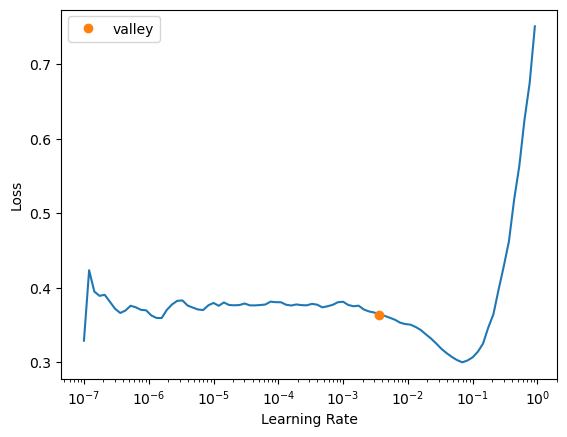

In [9]:
learn.lr_find()

In [10]:
#import torch.nn as nn
#Recommendations
def recommends(fav_movie, top_n=5):
    movie_factors = learn.model.movie_factors
    #we look up the movie in the movie factors
    idx = dls.classes['wine'].o2i[fav_movie]
    #find the movie with minimum distance
    distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
    #we sort the movies by distance
    idx = distances.argsort(descending=True)[1:top_n+1]
    #we return the movies
    recommended_movies = [dls.classes['wine'][i] for i in idx]
    return recommended_movies

recommended_movies = recommends('Pinot Grigio')
print("Recommended movies:")
for movie in recommended_movies:
    print(movie)

Recommended movies:
Schioppettino
Vitovska acciaio
Brachetto Piemonte
Nero d'Avola Sicilia
Brunello di Montalcino Riserva Vigna Paganelli


In [11]:
#def prediction for a user
def prediction_user_like(userId, title):
    userIdx = dls.classes['userId'].o2i[userId]
    movie_idx = dls.classes['wine'].o2i[title]

    # Make a prediction using the model's forward method
    prediction = learn.model.forward(tensor([[userIdx, movie_idx]])).item()

    return print(f"Predicted rating for user '{userId}' and '{title}': {prediction:.2f}")

prediction = prediction_user_like('13016d41-00bd-411c-83f5-2b95691696b7', 'chardonnay')
prediction = prediction_user_like(50, 'cabernet sauvignon')

Predicted rating for user '13016d41-00bd-411c-83f5-2b95691696b7' and 'chardonnay': 2.88
Predicted rating for user '50' and 'cabernet sauvignon': 2.74


In [12]:
# Show 20 rows of results
learn.show_results(n=20)

,userId,wine,rate,rate_pred
0,17,4,3,2.974516
1,5,121,4,3.083127
2,32,522,1,2.640457
3,148,247,5,4.311405
4,66,371,4,2.835177
5,141,569,1,2.723823
6,60,96,4,3.691217
7,148,176,3,2.985511
8,53,279,3,2.857147


In [13]:
g = df.groupby('wine')['rate'].count()
top_wines = g.sort_values(ascending=False).index.values[:50]
top_wines[:10]

array(["Moscata D'Asti Casaniere", 'Morellino di Scansano 2021',
       'Morellino di Scansano DOCG terre di talamo', 'Montefalco Rosso',
       'Nativi Gewürtztraminer', 'Vitovska acciaio', 'Chardonnay',
       "Nebbiolo d'Alba", 'Amarone',
       'Nespolino Rubicone Sangiovese - Merlot'], dtype=object)

In [14]:
from fastai.metrics import rmse

# Get predictions and targets
preds, targs = learn.get_preds()

# Calculate RMSE
error = rmse(preds, targs)
print(f'RMSE: {error}')

#MSE
error2 = mse(preds, targs)
print(f'MAE: {error2}')

#MAE
error3 = mae(preds, targs)
print(f'MAE: {error3}')

print(preds.shape)
print(targs.shape)

#transform the trags since they were a 2d tensor
targs = targs.squeeze()

#we create a dataframe with the predictions and the targets
df = pd.DataFrame({ 'targets': targs,'predictions': preds})
df.head(20)

#check the error
df['error'] = df['predictions'] - df['targets']


#print the error of the model
print(f"The error is : {df['error'].abs().mean()}")

df


RMSE: 1.3130254745483398
MAE: 1.7240358591079712
MAE: 1.1018407344818115
torch.Size([190])
torch.Size([190, 1])
The error is : 1.1018407344818115


,targets,predictions,error
0,5,2.978812,-2.021188
1,1,2.689964,1.689964
2,4,2.875097,-1.124903
3,2,2.679446,0.679446
4,3,2.748538,-0.251462
...,...,...,...
185,4,2.842256,-1.157744
186,2,2.929683,0.929683
187,4,3.691217,-0.308783
188,5,2.789173,-2.210827


In [15]:
#sort by best predictions and worst predictions
#sort col error from 0 to 5(-5)

df['abs_error'] = df['error'].abs()
best_predictions = df.sort_values(by='abs_error', ascending=True)
worst_predictions = df.sort_values(by='error', ascending=False)

#best predictions
best_predictions.head(10)

,targets,predictions,error,abs_error
84,3,2.999978,-0.000022,0.000022
45,3,3.004204,0.004204,0.004204
179,3,3.009851,0.009851,0.009851
7,3,2.988697,-0.011303,0.011303
150,3,2.987054,-0.012946,0.012946
21,3,3.013618,0.013618,0.013618
104,3,3.014409,0.014409,0.014409
68,3,2.985511,-0.014489,0.014489
158,3,2.982974,-0.017026,0.017026
172,3,3.017682,0.017682,0.017682


In [16]:
worst_predictions.head(10)

,targets,predictions,error,abs_error
61,1,3.662492,2.662492,2.662492
37,1,3.084072,2.084072,2.084072
62,1,3.040536,2.040536,2.040536
135,1,2.998919,1.998919,1.998919
38,1,2.989761,1.989761,1.989761
127,1,2.970599,1.970599,1.970599
52,1,2.928520,1.928520,1.928520
139,1,2.908910,1.908910,1.908910
103,1,2.890379,1.890379,1.890379
118,1,2.863796,1.863796,1.863796


In [17]:
def get_accuracy(df):
    # Count correct predictions
    correct = 0
    for _, row in df.iterrows():
        if round(row['predictions']) == round(row['targets']):
            correct += 1

    # Compute accuracy
    accuracy_percentage = correct / len(df)
    return accuracy_percentage * 100

# Get accuracy
accuracy = get_accuracy(df)
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 25.26%


In [18]:
preds, targs = learn.get_preds()

# Now you can check their shapes
print(f'Predictions shape: {preds.shape}')
print(f'Targets shape: {targs.shape}')

Predictions shape: torch.Size([190])
Targets shape: torch.Size([190, 1])


In [19]:
# Remove the extra dimension from targets
targs = targs.squeeze()

# Now the shapes should match
print(f'Predictions shape: {preds.shape}')
print(f'Targets shape: {targs.shape}')

Predictions shape: torch.Size([190])
Targets shape: torch.Size([190])


In [20]:
# Assuming `dls` is your DataLoader
for i, batch in enumerate(dls.valid):
    x, y = batch
    print(f'Batch {i+1}: {x.shape[0]}')

# Check the shape of predictions and targets
print(f'Predictions: {preds.shape[0]}')
print(f'Targets: {targs.shape[0]}')

Batch 1: 64
Batch 2: 64
Batch 3: 62
Predictions: 190
Targets: 190


In [21]:
print(f'Predictions: {preds.shape}')
print(f'Targets: {targs.shape}')

Predictions: torch.Size([190])
Targets: torch.Size([190])
